This notebook covers the content of the presentation "A Study of Applications of Phyiscs-Informed Neural Networks" by Antonio Falbo, Agustin Menjivar, Ava Oberrender, Alexey Prokudin, and Haley Rathman presented at the APS DNP 2025 meeting.

To begin, we examine the predictive issues of traditional neural networks outside the training domain, using sin(x) as our example. This neural network and example are based upon an AI/ML tutorial given by Nobuo Sato at the 2025 CFNS-SURGE Summer School. This tutorial can be accessed on YouTube here: [Nobuo Sato AI/ML Tutorial](https://www.youtube.com/watch?v=w5cuBBGyZ4Y).


First, we define and train a traditional neural network on the sin(x) function.

In [2]:
import sys
import numpy as np
from tqdm import tqdm
#! matplotlib
import matplotlib
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
#matplotlib.rc('text',usetex=True)
import pylab as py
from matplotlib import colors
import matplotlib.gridspec as gridspec
from IPython.display import display, clear_output
#! torch
import torch
import torch.nn as nn
import torch.distributions as dist
torch.set_default_dtype(torch.float64)
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
device
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


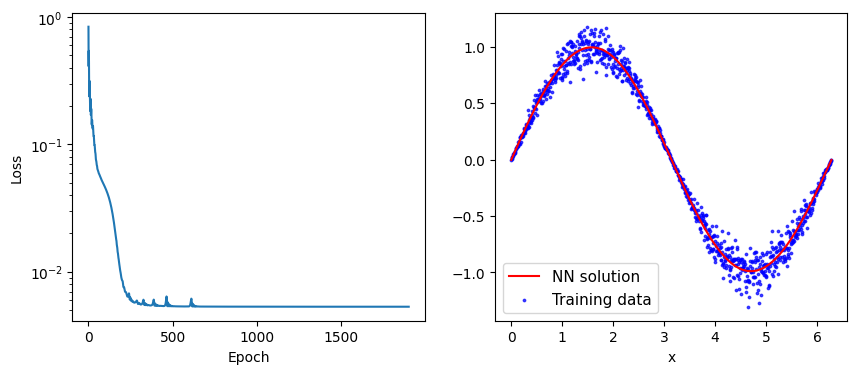

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR

fig, ax = py.subplots(1,2,figsize=(10,4))

Plot_model = True

# ------------------------------------------------------
# Define Training Data
# ------------------------------------------------------
x=torch.linspace(0.,2.*torch.pi,1000).to(device)
y=torch.sin(x).to(device)

# Add 10% Gaussian noise relative to y values
noise = 0.1 * y * torch.randn_like(y)
y = y + noise

# ------------------------------------------------------
# General Neural Network (NN) Model
# ------------------------------------------------------
class NN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        net = []
        for i in range(len(layers)-1):
            net.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                net.append(nn.Tanh())
        self.model = nn.Sequential(*net)

    def forward(self, x):
        return self.model(x)

# Define model (1 hidden layer, 20 nodes) using the NN class
layers = [1, 20, 1]
model = NN(layers).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.04)

# ------------------------------------------------------
# Training Loop
# ------------------------------------------------------
use_scheduler = True

n_epochs = 2000

if use_scheduler:
    scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)

losses = []

for epoch in range(n_epochs):
    optimizer.zero_grad()
    fake=model(x.view(-1,1).to(device))
    Loss=torch.mean((fake-y.view(-1,1).to(device))**2).to(device)
    Loss.backward()
    losses.append(Loss.item())
    optimizer.step()

    if use_scheduler:
      scheduler.step()

# ------------------------------------------------------
# Plot Training Results
# ------------------------------------------------------
    if Plot_model:
        if epoch % 100 == 0:
            clear_output(wait=True)
            ax[0].clear()
            ax[0].plot(losses)
            ax[0].set_xlabel('Epoch')
            ax[0].set_ylabel('Loss')
            ax[0].set_yscale('log')

            ax[1].clear()
            ax[1].plot(x.cpu().detach().numpy(),fake.cpu().detach().numpy(),'r', label = 'NN solution')
            ax[1].scatter(x.cpu().numpy(), y.cpu().numpy(), color='b', s=3, alpha=0.7, label = 'Training data')
            ax[1].legend(loc='lower left', fontsize=11)
            ax[1].set_xlabel('x')
            py.savefig('NN_sin_model_training.pdf')

Now, let's examine the neural network's prediction of sin(x) outside of the training region.

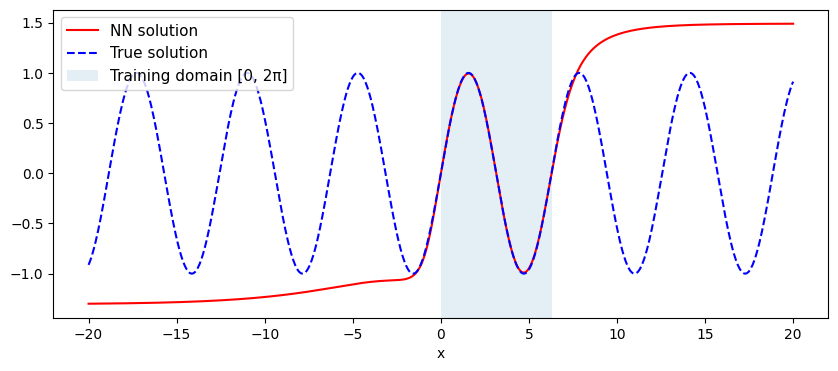

In [ ]:
# ------------------------------------------------------
# Define Prediction Domain
# ------------------------------------------------------
x1=torch.linspace(-20,20,800).to(device)
model.eval()

fake=model(x1.view(-1,1).to(device))
true=torch.sin(x1).to(device)

# ------------------------------------------------------
# Plot Prediction Results
# ------------------------------------------------------
train_left = 0.0
train_right = float(2 * torch.pi)

fig, ax = py.subplots(1,1,figsize=(10,4))
ax.plot(x1.cpu().detach().numpy(),fake.cpu().detach().numpy(),'r',label='NN solution')
ax.plot(x1.cpu().detach().numpy(),true.cpu().detach().numpy(),'b--',label='True solution')
ax.axvspan(train_left, train_right, alpha=0.12, label="Training domain [0, 2π]")
ax.legend(loc='upper left', fontsize=11)
ax.set_xlabel('x')
py.savefig('NN_sin_model_prediction.pdf')

Physics-Informed Neural Networks (PINNs) represent a solution to the predicitive issues of traditional neural networks by constraining the network's output to solutions of a governing ordinary or partial differential equation ([Raissi, Perdikaris, and Karniadakis, 2019](https://doi.org/10.1016/j.jcp.2018.10.045)).


To model sin(x), we will use the ordinary differential equation $\frac{d^2 f}{d x^2} = - f$, which has a solution $f(x) = A \sin(x) + B \cos(x)$. The boundary conditions used in the loss function will give us only the sin(x) solution to this equation.

Epoch 0, Loss = 2.6270642955
Epoch 1000, Loss = 0.0006147707


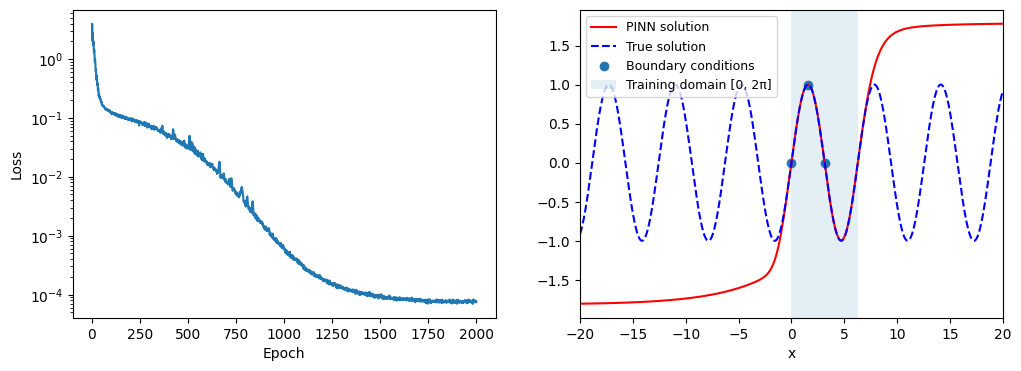

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------------------------------
# General Neural Network (NN) Model
# ------------------------------------------------------
class NN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        net = []
        for i in range(len(layers)-1):
            net.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                net.append(nn.Tanh())
        self.model = nn.Sequential(*net)

    def forward(self, x):
        return self.model(x)

# ------------------------------------------------------
# Training Loop
# ------------------------------------------------------
def train_pinn(model, ode_residual, x_bc, y_bc,
               n_epochs=2000, n_collocation=1000, lr=0.04, bc_weight=10.0):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []

    use_scheduler = True


    if use_scheduler:
      scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)


    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Collocation points in [0, 2π]
        x = torch.rand(n_collocation, 1, device=device, requires_grad=True) * (2 * torch.pi)
        y = model(x)

        # Residual loss
        residual = ode_residual(model, x, y)
        physics_loss = torch.mean(residual**2)

        # Boundary condition loss
        prediction = model(x_bc)
        bc_loss = torch.mean((prediction - y_bc)**2)

        # Total loss
        loss = physics_loss + bc_weight * bc_loss
        loss.backward()
        optimizer.step()

        if use_scheduler:
          scheduler.step()

        losses.append(loss.item())

        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss = {loss.item():.10f}")

    return losses

# ------------------------------------------------------
# ODE Loss
# ------------------------------------------------------
def ode_residual(model, x, y):
    dy_dx = torch.autograd.grad(y, x, torch.ones_like(y), create_graph=True)[0]
    d2y_dx2 = torch.autograd.grad(dy_dx, x, torch.ones_like(dy_dx), create_graph=True)[0]
    return d2y_dx2 + y

# ------------------------------------------------------
# Training the PINN
# ------------------------------------------------------
# Define model (1 hidden layer, 20 nodes)
layers = [1, 20, 1]
model = NN(layers).to(device)

# Boundary conditions: y(0)=0, y(pi/2)=1, y(pi)=0
x_bc = torch.tensor([0.0, float(torch.pi/2), float(torch.pi)], device=device).view(-1, 1)
y_bc = torch.sin(x_bc)

# Train
losses = train_pinn(
    model, ode_residual, x_bc, y_bc,
    n_epochs=2000,
    bc_weight=10.0
)

# ------------------------------------------------------
# Plot results
# ------------------------------------------------------
# Prediction/evaluation domain: [-20, 20]
x_eval = torch.linspace(-20.0, 20.0, 800, device=device).view(-1, 1)
y_eval = model(x_eval).detach().cpu().numpy()

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Solution
plt.subplot(1, 2, 2)
plt.plot(x_eval.cpu().numpy(), y_eval, 'r', label="PINN solution")
plt.plot(x_eval.cpu().numpy(), torch.sin(x_eval).cpu().numpy(), 'b--', label="True solution")
plt.scatter(x_bc.detach().cpu().numpy(), y_bc.detach().cpu().numpy(), label="Boundary conditions")

# Indicate training domain [0, 2π]
train_left = 0.0
train_right = float(2 * torch.pi)
plt.axvspan(train_left, train_right, alpha=0.12, label="Training domain [0, 2π]")

plt.legend(loc='upper left', fontsize=9)
plt.xlabel("x")
plt.xlim(-20, 20)
py.savefig('Initial_PINN_prediction.pdf')
plt.show()



To improve the PINN prediction in the unmeasured region and impose periodicity upon the PINN output, we employ the Fourier Neural Network model, that mimics a Fourier expansion in its output ([Ngom and Marin, 2021](https://doi.org/10.1002/sam.11531)). This model specializes in approximating periodic functions through a cosine activation function and periodicity condition in the loss function. This model is used with a PINN to achieve a Physics-Informed Fourier Neural Network (PIFNN).

Epoch 0, Loss = 9.3692146765
Epoch 1000, Loss = 0.0000005528


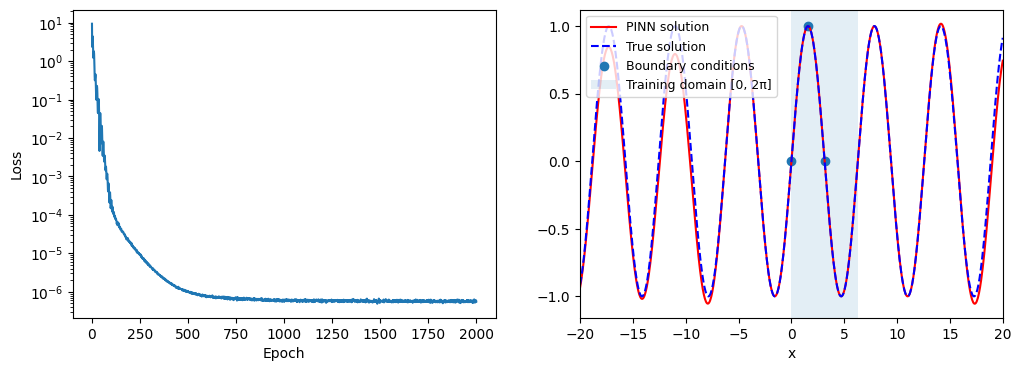

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------------------------------
# Cosine Activation Module
# ------------------------------------------------------
class CosineActivation(nn.Module):
    def forward(self, x):
        return torch.cos(x)

# ------------------------------------------------------
# General Neural Network (NN) Model
# ------------------------------------------------------
class NN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        net = []
        for i in range(len(layers)-1):
            net.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                net.append(CosineActivation())
        self.model = nn.Sequential(*net)

    def forward(self, x):
        return self.model(x)

# ------------------------------------------------------
# Training Loop
# ------------------------------------------------------
def train_pinn(model, ode_residual, x_bc, y_bc, periodic_loss_fn,
               n_epochs=2000, n_collocation=1000, lr=0.04, bc_weight=10.0):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []

    use_scheduler = True


    if use_scheduler:
      scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)


    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Collocation points in [0, 2π]
        x = torch.rand(n_collocation, 1, device=device, requires_grad=True) * (2 * torch.pi)
        y = model(x)

        # Residual loss
        residual = ode_residual(model, x, y)
        physics_loss = torch.mean(residual**2)

        # Boundary condition loss
        prediction = model(x_bc)
        bc_loss = torch.mean((prediction - y_bc)**2)

        # Periodicity condition loss (period = 2π)
        periodicity_loss = periodic_loss_fn(model, x)
        periodicity_loss = torch.mean(periodicity_loss)

        # Total loss
        loss = physics_loss + bc_weight * bc_loss + periodicity_loss
        loss.backward()
        optimizer.step()

        if use_scheduler:
          scheduler.step()

        losses.append(loss.item())

        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss = {loss.item():.10f}")

    return losses

# ------------------------------------------------------
# ODE Loss and Periodicity Loss
# ------------------------------------------------------
def ode_residual(model, x, y):
    dy_dx = torch.autograd.grad(y, x, torch.ones_like(y), create_graph=True)[0]
    d2y_dx2 = torch.autograd.grad(dy_dx, x, torch.ones_like(dy_dx), create_graph=True)[0]
    return d2y_dx2 + y

def periodic_loss_fn(model, x):
    # modeled after Fourier NN loss fn
    period = 2 * torch.pi
    bc1 = model(x - period) - model(x)
    bc2 = model(x + period) - model(x)
    return (bc1**2) + (bc2**2)

# ------------------------------------------------------
# Training the PINN
# ------------------------------------------------------
# Define model (1 hidden layer, 20 nodes)
layers = [1, 20, 1]
model = NN(layers).to(device)

# Boundary conditions: y(0)=0, y(pi/2)=1, y(pi)=0
x_bc = torch.tensor([0.0, float(torch.pi/2), float(torch.pi)], device=device).view(-1, 1)
y_bc = torch.sin(x_bc)

# Train
losses = train_pinn(
    model, ode_residual, x_bc, y_bc, periodic_loss_fn,
    n_epochs=2000,
    bc_weight=10.0
)

# ------------------------------------------------------
# Plot results
# ------------------------------------------------------
# Prediction/evaluation domain: [-20, 20]
x_eval = torch.linspace(-20.0, 20.0, 800, device=device).view(-1, 1)
y_eval = model(x_eval).detach().cpu().numpy()

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.yscale('log') # Set y-axis to logarithmic scale
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Solution
plt.subplot(1, 2, 2)
plt.plot(x_eval.cpu().numpy(), y_eval, 'r', label="PINN solution")
plt.plot(x_eval.cpu().numpy(), torch.sin(x_eval).cpu().numpy(), 'b--', label="True solution")
plt.scatter(x_bc.detach().cpu().numpy(), y_bc.detach().cpu().numpy(), label="Boundary conditions")

# Indicate training domain [0, 2π]
train_left = 0.0
train_right = float(2 * torch.pi)
plt.axvspan(train_left, train_right, alpha=0.12, label="Training domain [0, 2π]")

plt.legend(loc='upper left', fontsize=9)
plt.xlabel("x")
plt.xlim(-20, 20)
py.savefig('Final_PIFNN_prediction.pdf')
plt.show()


Epoch 0, Loss = 17.4783520487
Epoch 1000, Loss = 0.0000213152


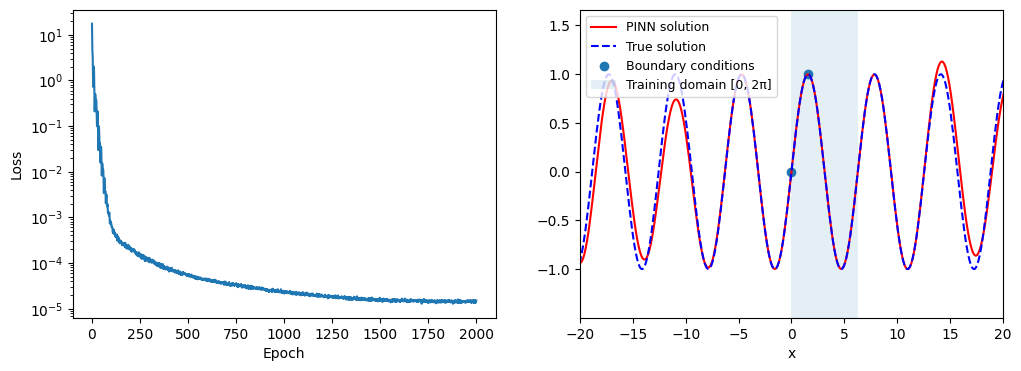

In [9]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pylab as py
from torch.optim.lr_scheduler import CosineAnnealingLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------------------------------
# Cosine Activation Module
# ------------------------------------------------------
class CosineActivation(nn.Module):
    def forward(self, x):
        return torch.cos(x)

# ------------------------------------------------------
# General Neural Network (NN) Model
# ------------------------------------------------------
class NN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        net = []
        for i in range(len(layers)-1):
            net.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                net.append(CosineActivation())
        self.model = nn.Sequential(*net)

    def forward(self, x):
        return self.model(x)

# ------------------------------------------------------
# Training Loop
# ------------------------------------------------------
def train_pinn(model, ode_residual, x_bc, y_bc, periodic_loss_fn,
               n_epochs=2000, n_collocation=1000, lr=0.04, bc_weight=10.0):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []

    use_scheduler = True


    if use_scheduler:
      scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)


    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Collocation points in [0, 2π]
        x = torch.rand(n_collocation, 1, device=device, requires_grad=True) * (2 * torch.pi)
        y = model(x)

        # Residual loss
        residual = ode_residual(model, x, y)
        physics_loss = torch.mean(residual**2)

        # Boundary condition loss
        prediction = model(x_bc)
        bc_loss = torch.mean((prediction - y_bc)**2)

        # Periodicity condition loss (period = 2π)
        periodicity_loss = periodic_loss_fn(model, x)
        periodicity_loss = torch.mean(periodicity_loss)

        # Total loss
        loss = physics_loss + bc_weight * bc_loss + periodicity_loss
        loss.backward()
        optimizer.step()

        if use_scheduler:
          scheduler.step()

        losses.append(loss.item())

        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss = {loss.item():.10f}")

    return losses

# ------------------------------------------------------
# ODE Loss and Periodicity Loss
# ------------------------------------------------------
def ode_residual(model, x, y):
    dy_dx = torch.autograd.grad(y, x, torch.ones_like(y), create_graph=True)[0]
    d2y_dx2 = torch.autograd.grad(dy_dx, x, torch.ones_like(dy_dx), create_graph=True)[0]
    return d2y_dx2 + y

def periodic_loss_fn(model, x):
    # modeled after Fourier NN loss fn
    period = 2 * torch.pi
    bc1 = model(x - period) - model(x)
    bc2 = model(x + period) - model(x)
    return (bc1**2) + (bc2**2)

# ------------------------------------------------------
# Training the PINN
# ------------------------------------------------------
# Define model (1 hidden layer, 20 nodes)
layers = [1, 20, 1]
model = NN(layers).to(device)

# Boundary conditions: y(0)=0, y(pi/2)=1, y(pi)=0
#x_bc = torch.tensor([0.0, float(torch.pi/2), float(torch.pi)], device=device).view(-1, 1)
x_bc = torch.tensor([0.0, float(torch.pi/2)], device=device).view(-1, 1)
y_bc = torch.sin(x_bc)

# Train
losses = train_pinn(
    model, ode_residual, x_bc, y_bc, periodic_loss_fn,
    n_epochs=2000,
    bc_weight=10.0
)

# ------------------------------------------------------
# Plot results
# ------------------------------------------------------
# Prediction/evaluation domain: [-20, 20]
x_eval = torch.linspace(-50.0, 50.0, 800, device=device).view(-1, 1)
y_eval = model(x_eval).detach().cpu().numpy()

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.yscale('log') # Set y-axis to logarithmic scale
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Solution
plt.subplot(1, 2, 2)
plt.plot(x_eval.cpu().numpy(), y_eval, 'r', label="PINN solution")
plt.plot(x_eval.cpu().numpy(), torch.sin(x_eval).cpu().numpy(), 'b--', label="True solution")
plt.scatter(x_bc.detach().cpu().numpy(), y_bc.detach().cpu().numpy(), label="Boundary conditions")

# Indicate training domain [0, 2π]
train_left = 0.0
train_right = float(2 * torch.pi)
plt.axvspan(train_left, train_right, alpha=0.12, label="Training domain [0, 2π]")

plt.legend(loc='upper left', fontsize=9)
plt.xlabel("x")
plt.xlim(-20, 20)
py.savefig('Final_PIFNN_prediction.pdf')
plt.show()


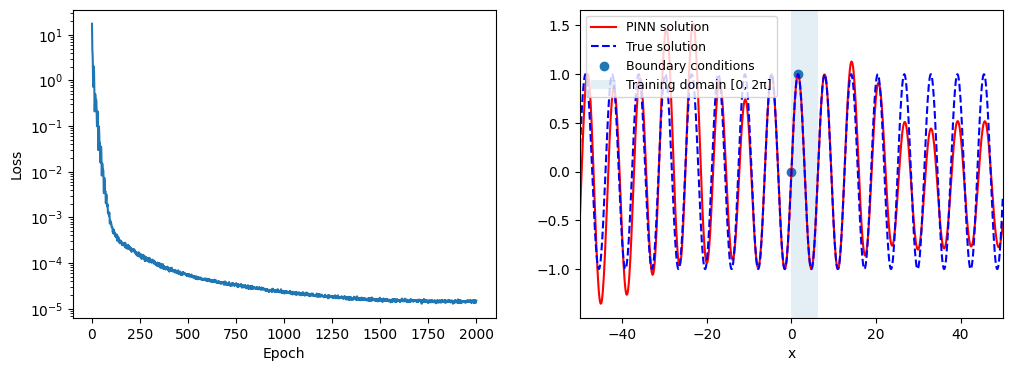

In [10]:
# ------------------------------------------------------
# Plot results
# ------------------------------------------------------
# Prediction/evaluation domain: [-20, 20]
x_eval = torch.linspace(-50.0, 50.0, 800, device=device).view(-1, 1)
y_eval = model(x_eval).detach().cpu().numpy()

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.yscale('log') # Set y-axis to logarithmic scale
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Solution
plt.subplot(1, 2, 2)
plt.plot(x_eval.cpu().numpy(), y_eval, 'r', label="PINN solution")
plt.plot(x_eval.cpu().numpy(), torch.sin(x_eval).cpu().numpy(), 'b--', label="True solution")
plt.scatter(x_bc.detach().cpu().numpy(), y_bc.detach().cpu().numpy(), label="Boundary conditions")

# Indicate training domain [0, 2π]
train_left = 0.0
train_right = float(2 * torch.pi)
plt.axvspan(train_left, train_right, alpha=0.12, label="Training domain [0, 2π]")

plt.legend(loc='upper left', fontsize=9)
plt.xlabel("x")
plt.xlim(-50, 50)
py.savefig('Final_PIFNN_prediction.pdf')
plt.show()